In [161]:
import pandas as pd

### Columns encoding

In [162]:
df_mayor = pd.read_csv('data/data_mayoral.csv')

In [163]:
# Gender encoding
df_mayor['gender_est_rep'] = df_mayor['gender_est_rep'].map({'M': 1, 'F': 0})
df_mayor['gender_est_dem'] = df_mayor['gender_est_dem'].map({'M': 1, 'F': 0})

In [164]:
# State encoding
state_categories_df = pd.read_csv('data/state_categories.csv')

# Merge with df_mayor
df_mayor = df_mayor.merge(state_categories_df, on='state_abb', how="left")
df_mayor.rename(columns={"category": "state_category"}, inplace=True)
df_mayor.drop(columns=["state_abb"], inplace=True)

# Convert 'state_category' to one-hot encoding
df_mayor = pd.get_dummies(df_mayor, columns=['state_category'], prefix='state_category')
for col in df_mayor.filter(like='state_category').columns:
    df_mayor[col] = df_mayor[col].astype(int)

In [165]:
df_mayor.columns

Index(['geo_name', 'year', 'contest', 'fips', 'full_name_rep',
       'vote_share_rep', 'incumbent_rep', 'contributor.cfscore_rep',
       'prob_democrat_rep', 'gender_est_rep', 'race_est_rep', 'pid_est_rep',
       'full_name_dem', 'vote_share_dem', 'incumbent_dem',
       'contributor.cfscore_dem', 'prob_democrat_dem', 'gender_est_dem',
       'race_est_dem', 'pid_est_dem', 'percent_women', 'pres_pctD', 'total',
       'hispanic', 'white', 'black', 'asian', 'state_category_dem_state',
       'state_category_rep_state', 'state_category_swing_state'],
      dtype='object')

In [166]:
df_mayor["race_est_rep_white"] = df_mayor["race_est_rep"].apply(lambda x: 1 if x == "white" else 0)
df_mayor["race_est_dem_white"] = df_mayor["race_est_dem"].apply(lambda x: 1 if x == "white" else 0)

In [167]:
df_mayor.drop(columns = ["year","geo_name", "contest", "full_name_rep", "full_name_dem", "pid_est_rep", "race_est_rep", "race_est_dem", "pid_est_dem"], inplace = True)

In [168]:
df_mayor_reg = df_mayor.copy()
df_mayor_class = df_mayor.copy()
df_mayor_class["winner_dem"] = df_mayor_class.apply(lambda x: 1 if x["vote_share_dem"] >= x["vote_share_rep"] else 0, axis = 1)
df_mayor_reg["winner_dem"] = df_mayor_reg.apply(lambda x: 1 if x["vote_share_dem"] >= x["vote_share_rep"] else 0, axis = 1)
df_mayor_class.drop(columns = ["vote_share_rep", "vote_share_dem"], inplace = True)
df_mayor_reg.drop(columns = ["vote_share_rep"], inplace = True)

In [169]:
df_mayor_class.columns

Index(['fips', 'incumbent_rep', 'contributor.cfscore_rep', 'prob_democrat_rep',
       'gender_est_rep', 'incumbent_dem', 'contributor.cfscore_dem',
       'prob_democrat_dem', 'gender_est_dem', 'percent_women', 'pres_pctD',
       'total', 'hispanic', 'white', 'black', 'asian',
       'state_category_dem_state', 'state_category_rep_state',
       'state_category_swing_state', 'race_est_rep_white',
       'race_est_dem_white', 'winner_dem'],
      dtype='object')

# Feature Selection

In [170]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

def feature_selection_slicer(X, selected_indices):
    return X.iloc[:, selected_indices]

# Feature Selection using Univariate Feature Selection (ANOVA F-test)
def univariate_feature_selection(X, y, k=3):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    return feature_selection_slicer(X, selected_features), selected_features

# Feature Selection using Feature Importance from RandomForest
def feature_importance_selection(X, y, num_features=3):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:num_features]
    return feature_selection_slicer(X, indices), indices

# Feature Selection using Recursive Feature Elimination (RFE)
def recursive_feature_elimination(X, y, num_features=3):
    model = RandomForestClassifier(random_state=42)
    selector = RFE(model, n_features_to_select=num_features, step=1)
    selector.fit(X, y)
    selected_features = selector.get_support(indices=True)
    return feature_selection_slicer(X, selected_features), selected_features

# Load dataset
X, y = df_mayor_class.drop(columns = ["winner_dem"]), df_mayor_class.winner_dem

# Apply feature selection
k = 16  # Number of features to select
X_uni, selected_uni = univariate_feature_selection(X, y, k=k)
X_importance, selected_importance = feature_importance_selection(X, y, num_features=k)
X_rfe, selected_rfe = recursive_feature_elimination(X, y, num_features=k)

# Print selected features for each method
print(f"Selected features (Univariate): {selected_uni}")
print(f"Selected features (Feature Importance): {selected_importance}")
print(f"Selected features (RFE): {selected_rfe}")

# aggregate scores from the three methods to get one list
scores = {}
for feat_selec_version in [selected_uni, selected_importance, selected_rfe]:
    for i in feat_selec_version:
        if i in scores:
            scores[i] = scores[i] + 1
        else:
            scores[i] = 1

keepers= sorted(scores, key=scores.get, reverse=True)[:15] 
class_cols = []
reg_cols = []
for i in range(len(X.columns)):
    if i in selected_rfe:
        class_cols.append(X.columns[i])
        reg_cols.append(X.columns[i])
class_cols.append("winner_dem")
reg_cols.append("vote_share_dem")
reg_cols.append("winner_dem")

df_mayor_class = df_mayor_class[class_cols]
df_mayor_reg = df_mayor_reg[reg_cols]

Selected features (Univariate): [ 0  1  3  4  5  7  8  9 10 12 13 14 15 17 18 19]
Selected features (Feature Importance): [ 1 10  5 14 15 13 11  6  2 12  0  9  7  3  8 17]
Selected features (RFE): [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 18]


In [171]:
print(class_cols)

['fips', 'incumbent_rep', 'contributor.cfscore_rep', 'prob_democrat_rep', 'incumbent_dem', 'contributor.cfscore_dem', 'prob_democrat_dem', 'gender_est_dem', 'percent_women', 'pres_pctD', 'total', 'hispanic', 'white', 'black', 'asian', 'state_category_swing_state', 'winner_dem']


# Regression

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load dataset
X, ys = df_mayor_reg.drop(columns = ["vote_share_dem", "winner_dem"]), [df_mayor_reg.vote_share_dem, df_mayor_reg.winner_dem]

# Pipelines + Param Grids
pipelines = {
    "DecisionTree": Pipeline([
        ("clf", DecisionTreeRegressor(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostRegressor(random_state=42))
    ]),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVR())
    ]),
    "LinearRegression": Pipeline([
        ("clf", LinearRegression())
    ]),
    "Dummy": Pipeline([
        ("clf", DummyRegressor())
    ])
}

param_grids = {
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.01, 0.1, 1]
    },
    "SVM": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": ["scale", "auto"]
    },
    "LinearRegression": {
        # No hyperparams to tune for standard LinearRegression
    },
    "Dummy": {
        # No hyperparams to tune for standard LinearRegression
    },
    
}

# Nested Cross-Validation + Full Predictions
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Results container
regression_results = {}

for model_name, pipeline in pipelines.items():
    # Container to store metrics for each fold
    fold_mse = []
    fold_r2 = []
    fold_mse_def = []
    fold_r2_def = []
    fold_accuracies_def = []
    fold_f1_scores_def = []
    fold_accuracies = []
    fold_f1_scores = []
    
    # Outer loop
    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = ys[0].iloc[train_idx], ys[0].iloc[test_idx]
        _, classification_y = ys[1].iloc[train_idx], ys[1].iloc[test_idx]
        
        #check out the default performance
        pipeline.fit(X_train, y_train)
        y_pred_fold_def = pipeline.predict(X_test)
        mse_def = mean_squared_error(y_test, y_pred_fold_def)
        r2_def = r2_score(y_test, y_pred_fold_def)
        fold_mse_def.append(mse_def)
        fold_r2_def.append(r2_def)
        
        #check out the classification performance of the default
        y_class_fold_def = y_pred_fold_def.copy()
        y_class_fold_def[y_class_fold_def >= 0.5] = 1
        y_class_fold_def[y_class_fold_def < 0.5] = 0
        accuracy_def = accuracy_score(classification_y, y_class_fold_def)
        f1_def = f1_score(classification_y, y_class_fold_def)
        fold_accuracies_def.append(accuracy_def)
        fold_f1_scores_def.append(f1_def)
        
        
        # Inner CV: GridSearch on training folds
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids.get(model_name, {}),
            scoring="neg_mean_squared_error",
            cv=inner_cv,  # Explicitly pass inner_cv here
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        # Best model from inner cross-validation
        best_model = grid_search.best_estimator_
        
        # Predict on the outer test fold
        y_pred_fold = best_model.predict(X_test)
        
        # Compute metrics for this fold
        mse = mean_squared_error(y_test, y_pred_fold)
        r2 = r2_score(y_test, y_pred_fold)
        
        # Store the metrics for this fold
        fold_mse.append(mse)
        fold_r2.append(r2)
        
        #also check thresholded classification
        #check out the classification performance of the default
        y_class_fold = y_pred_fold.copy()
        y_class_fold[y_class_fold >= 0.5] = 1
        y_class_fold[y_class_fold < 0.5] = 0
        accuracy = accuracy_score(classification_y, y_class_fold)
        f1 = f1_score(classification_y, y_class_fold)
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
    
    # Average metrics across folds
    avg_mse_def = np.mean(fold_mse_def)
    avg_r2_def = np.mean(fold_r2_def)
    avg_mse = np.mean(fold_mse)
    avg_r2 = np.mean(fold_r2)
    avg_accuracy_def = np.mean(fold_accuracies_def)
    avg_f1_def = np.mean(fold_f1_scores_def)
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    
    # Store results
    regression_results[model_name] = {
        "avg_mse_def": avg_mse_def,
        "avg_r2_def": avg_r2_def,
        "fold_mse_def": fold_mse_def,
        "fold_r2_def": fold_r2_def,
        "avg_mse": avg_mse,
        "avg_r2": avg_r2,
        "fold_mse": fold_mse,
        "fold_r2": fold_r2,
        "avg_accuracy_def": avg_accuracy_def,
        "avg_f1_def": avg_f1_def,            
        "avg_accuracy": avg_accuracy,        
        "avg_f1": avg_f1                   
    }

# Print results
print("Nested CV Results (Average Across Folds):")
for model_name, results in regression_results.items():
    print(f"    {model_name} Default -> Avg MSE: {results['avg_mse_def']:.4f}, Avg R^2: {results['avg_r2_def']:.4f}")
    print(f"    {model_name} Tuned -> Avg MSE: {results['avg_mse']:.4f}, Avg R^2: {results['avg_r2']:.4f}")
    
print("Thresholded Classification Results (Average Across Folds):")
for model_name, results in regression_results.items():
    print(f"    {model_name} Default -> Avg Acc: {results['avg_accuracy_def']:.4f}, Avg F1: {results['avg_f1_def']:.4f}")
    print(f"    {model_name} Tuned -> Avg Acc: {results['avg_accuracy']:.4f}, Avg F1: {results['avg_f1']:.4f}")


# Viz
#model_names = list(regression_results.keys())
#mse_values = [regression_results[m]["avg_mse"] for m in model_names]
#r2_values = [regression_results[m]["avg_r2"] for m in model_names]

# 1) Bar Chart: MSE
#plt.figure(figsize=(10, 6))
#plt.bar(model_names, mse_values, color='skyblue', edgecolor='black')
#plt.ylabel("Mean Squared Error")
#plt.title("Model Comparison: MSE (Nested CV)")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

# 2) Bar Chart: R^2
#plt.figure(figsize=(10, 6))
#plt.bar(model_names, r2_values, color='lightgreen', edgecolor='black')
#plt.ylabel("R^2 Score")
#plt.title("Model Comparison: R^2 (Nested CV)")
#plt.ylim(0, 1)
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

# # 3) Scatter & Residual Plots
# for model_name, result in regression_results.items():
#     y_pred = result["y_pred_full"]
    
#     # Scatter Plot: True vs Predicted
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y, y_pred, alpha=0.6)
#     plt.plot([y.min(), y.max()], [y.min(), y.max()],
#              color="red", linestyle="--", linewidth=2)
#     plt.title(f"True vs. Predicted: {model_name} (Nested CV)")
#     plt.xlabel("True Values (y)")
#     plt.ylabel("Predicted Values")
#     plt.tight_layout()
#     plt.show()
    
#     # Residual Plot
#     residuals = y - y_pred
#     plt.figure(figsize=(8, 6))
#     sns.histplot(residuals, kde=True, bins=30)
#     plt.title(f"Residuals Distribution: {model_name} (Nested CV)")
#     plt.xlabel("Residuals (y - y_pred)")
#     plt.ylabel("Frequency")
#     plt.axvline(0, color="red", linestyle="--", linewidth=2)
#     plt.tight_layout()
#     plt.show()


Nested CV Results (Average Across Folds):
    DecisionTree Default -> Avg MSE: 0.0311, Avg R^2: -0.0815
    DecisionTree Tuned -> Avg MSE: 0.0195, Avg R^2: 0.3266
    AdaBoost Default -> Avg MSE: 0.0179, Avg R^2: 0.3841
    AdaBoost Tuned -> Avg MSE: 0.0171, Avg R^2: 0.4103
    SVM Default -> Avg MSE: 0.0186, Avg R^2: 0.3554
    SVM Tuned -> Avg MSE: 0.0169, Avg R^2: 0.4143
    LinearRegression Default -> Avg MSE: 0.0174, Avg R^2: 0.3975
    LinearRegression Tuned -> Avg MSE: 0.0174, Avg R^2: 0.3975
    Dummy Default -> Avg MSE: 0.0291, Avg R^2: -0.0017
    Dummy Tuned -> Avg MSE: 0.0291, Avg R^2: -0.0017
Thresholded Classification Results (Average Across Folds):
    DecisionTree Default -> Avg Acc: 0.6689, Avg F1: 0.7219
    DecisionTree Tuned -> Avg Acc: 0.7258, Avg F1: 0.7834
    AdaBoost Default -> Avg Acc: 0.7379, Avg F1: 0.7801
    AdaBoost Tuned -> Avg Acc: 0.7460, Avg F1: 0.7817
    SVM Default -> Avg Acc: 0.7366, Avg F1: 0.7814
    SVM Tuned -> Avg Acc: 0.7419, Avg F1: 0.7901


# Classification

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load dataset
X, y = df_mayor_class.drop(columns = ["winner_dem"]), df_mayor_class.winner_dem


pipelines = {
    "DecisionTree": Pipeline([
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "SVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(random_state=42))
    ]),
    "NaiveBayes": Pipeline([
        ("clf", GaussianNB())
    ]),
    "Dummy": Pipeline([
        ("clf", DummyClassifier())
    ])
}
param_grids = {
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.01, 0.1, 1]
    },
    "SVC": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": ["scale", "auto"]
    },
    "NaiveBayes": {
        "clf__var_smoothing": [1e-09, 1e-08, 1e-07]
    },
    "Dummy": {
        # No hyperparams to tune for standard LinearRegression
    },
}

# Nested Cross Validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store overall results
classification_results = {}

for model_name, pipeline in pipelines.items():
    # Containers to store per-fold metrics
    fold_accuracies = []
    fold_f1_scores = []
    fold_accuracies_def = []
    fold_f1_scores_def = []
    
    # Outer loop
    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        #check out the default performance
        pipeline.fit(X_train, y_train)
        y_pred_fold_def = pipeline.predict(X_test)
        accuracy_def = accuracy_score(y_test, y_pred_fold_def)
        f1_def = f1_score(y_test, y_pred_fold_def)
        fold_accuracies_def.append(accuracy_def)
        fold_f1_scores_def.append(f1_def)
        
        # Inner CV: GridSearch on training folds
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids.get(model_name, {}),
            scoring="accuracy",  # Metric for inner CV
            cv=inner_cv,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        # Best model from inner cross-validation
        best_model = grid_search.best_estimator_
        
        # Predict on the outer test fold
        y_pred_fold = best_model.predict(X_test)
        
        # Compute metrics for this fold
        fold_accuracy = accuracy_score(y_test, y_pred_fold)
        fold_f1 = f1_score(y_test, y_pred_fold)
        
        # Store the metrics for this fold
        fold_accuracies.append(fold_accuracy)
        fold_f1_scores.append(fold_f1)
    
    # Average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1_score = np.mean(fold_f1_scores)
    avg_accuracy_def = np.mean(fold_accuracies_def)
    avg_f1_score_def = np.mean(fold_f1_scores_def)
    
    # Store results
    classification_results[model_name] = {
        "avg_accuracy": avg_accuracy,
        "avg_f1_score": avg_f1_score,
        "fold_accuracies": fold_accuracies,
        "fold_f1_scores": fold_f1_scores,
        "avg_accuracy_def": avg_accuracy_def,
        "avg_f1_score_def": avg_f1_score_def,
        "fold_accuracies_def": fold_accuracies_def,
        "fold_f1_scores_def": fold_f1_scores_def
    }

# Print results
print("Nested CV Results (Average Across Folds):")
for model_name, results in classification_results.items():
    print(f"{model_name} Default -> Avg Accuracy: {results['avg_accuracy_def']:.4f}, Avg F1 Score: {results['avg_f1_score_def']:.4f}")
    print(f"{model_name} Tuned -> Avg Accuracy: {results['avg_accuracy']:.4f}, Avg F1 Score: {results['avg_f1_score']:.4f}")


c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

Nested CV Results (Average Across Folds):
DecisionTree Default -> Avg Accuracy: 0.6736, Avg F1 Score: 0.7223
DecisionTree Tuned -> Avg Accuracy: 0.7064, Avg F1 Score: 0.7531
AdaBoost Default -> Avg Accuracy: 0.7433, Avg F1 Score: 0.7899
AdaBoost Tuned -> Avg Accuracy: 0.7473, Avg F1 Score: 0.7975
SVC Default -> Avg Accuracy: 0.7493, Avg F1 Score: 0.7984
SVC Tuned -> Avg Accuracy: 0.7433, Avg F1 Score: 0.7983
NaiveBayes Default -> Avg Accuracy: 0.5891, Avg F1 Score: 0.7396
NaiveBayes Tuned -> Avg Accuracy: 0.5891, Avg F1 Score: 0.7396
Dummy Default -> Avg Accuracy: 0.5931, Avg F1 Score: 0.7444
Dummy Tuned -> Avg Accuracy: 0.5931, Avg F1 Score: 0.7444


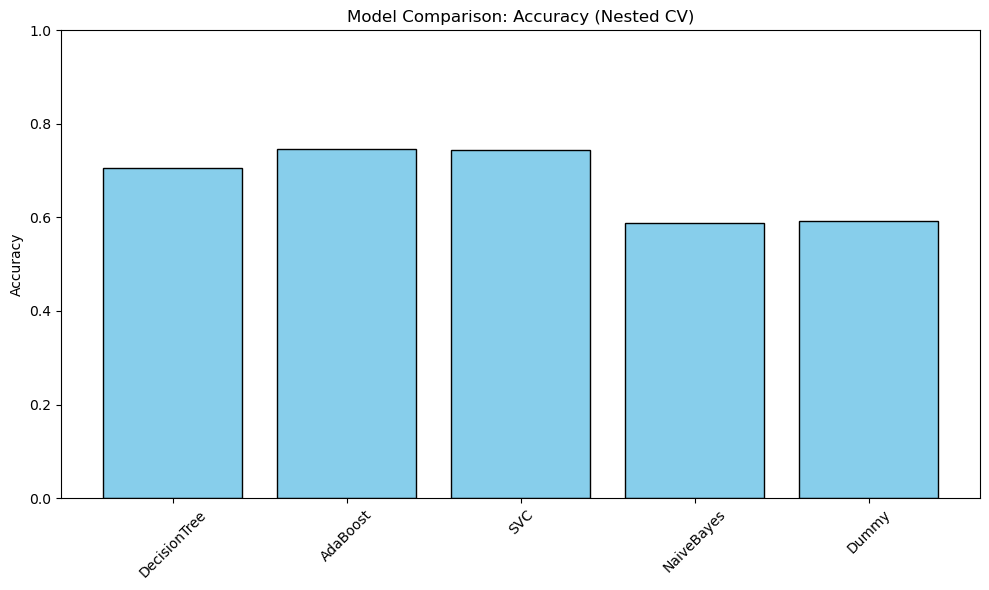

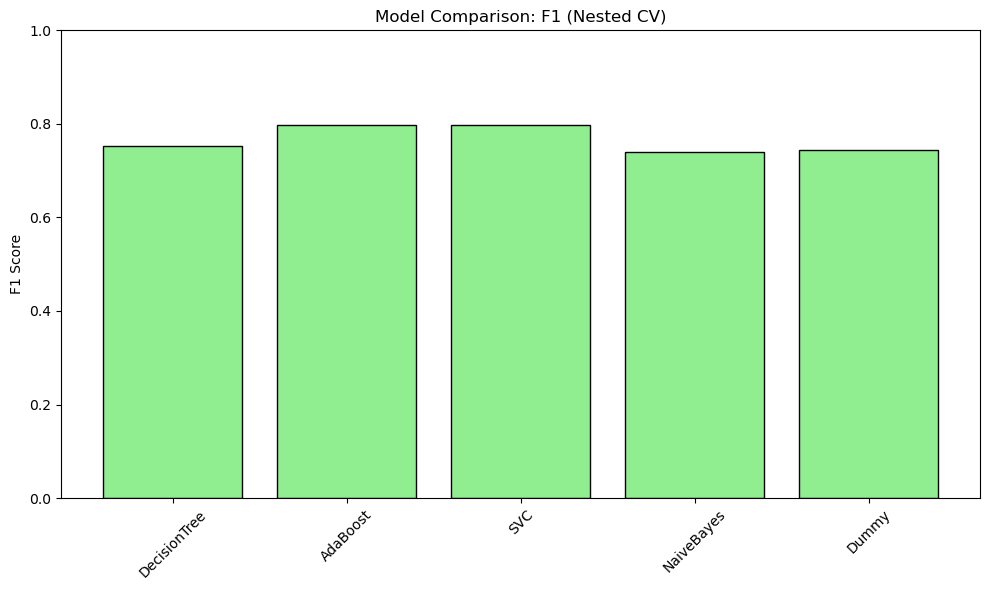

In [174]:
# Viz
model_names = list(classification_results.keys())
accuracy_values = [classification_results[m]["avg_accuracy"] for m in model_names]
f1_values = [classification_results[m]["avg_f1_score"] for m in model_names]

# 1) Bar Chart: Accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color='skyblue', edgecolor='black')
plt.ylabel("Accuracy")
plt.title("Model Comparison: Accuracy (Nested CV)")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Bar Chart: F1 Score
plt.figure(figsize=(10, 6))
plt.bar(model_names, f1_values, color='lightgreen', edgecolor='black')
plt.ylabel("F1 Score")
plt.title("Model Comparison: F1 (Nested CV)")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # 3) Confusion Matrices
# for model_name, result in classification_results.items():
#     y_pred = result["y_pred_full"]
#     cm = confusion_matrix(y, y_pred)
    
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
#     plt.title(f"Confusion Matrix: {model_name}")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.tight_layout()
#     plt.show()


# Models Trained on Baseline Datasets

In [179]:
baseline_df = df_mayor_class[['total', 'hispanic',
       'white', 'black', 'asian', 'winner_dem']]
baseline_info_df = df_mayor_class[
       ['fips', 'incumbent_rep', 'contributor.cfscore_rep', 'prob_democrat_rep', 'incumbent_dem', 'contributor.cfscore_dem', 'prob_democrat_dem', 'gender_est_dem', 'winner_dem']
       ] 

In [182]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# 1. Load your data (for example, Iris)
X, y = baseline_df.drop(columns = ["winner_dem"]), baseline_df["winner_dem"]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

pipelines = {
    "DecisionTree": Pipeline([
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "SVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(random_state=42))
    ]),
    "NaiveBayes": Pipeline([
        ("clf", GaussianNB())
    ]),
    "Dummy": Pipeline([
        ("clf", DummyClassifier())
    ])
}
param_grids = {
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.01, 0.1, 1]
    },
    "SVC": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": ["scale", "auto"]
    },
    "NaiveBayes": {
        "clf__var_smoothing": [1e-09, 1e-08, 1e-07]
    },
    "Dummy": {
        # No hyperparams to tune for standard LinearRegression
    },
}

# Nested Cross Validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store overall results
classification_results = {}

for model_name, pipeline in pipelines.items():
    # Containers to store per-fold metrics
    fold_accuracies = []
    fold_f1_scores = []
    fold_accuracies_def = []
    fold_f1_scores_def = []
    
    # Outer loop
    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        #check out the default performance
        pipeline.fit(X_train, y_train)
        y_pred_fold_def = pipeline.predict(X_test)
        accuracy_def = accuracy_score(y_test, y_pred_fold_def)
        f1_def = f1_score(y_test, y_pred_fold_def)
        fold_accuracies_def.append(accuracy_def)
        fold_f1_scores_def.append(f1_def)
        
        # Inner CV: GridSearch on training folds
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids.get(model_name, {}),
            scoring="accuracy",  # Metric for inner CV
            cv=inner_cv,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        # Best model from inner cross-validation
        best_model = grid_search.best_estimator_
        
        # Predict on the outer test fold
        y_pred_fold = best_model.predict(X_test)
        
        # Compute metrics for this fold
        fold_accuracy = accuracy_score(y_test, y_pred_fold)
        fold_f1 = f1_score(y_test, y_pred_fold)
        
        # Store the metrics for this fold
        fold_accuracies.append(fold_accuracy)
        fold_f1_scores.append(fold_f1)
    
    # Average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1_score = np.mean(fold_f1_scores)
    avg_accuracy_def = np.mean(fold_accuracies_def)
    avg_f1_score_def = np.mean(fold_f1_scores_def)
    
    # Store results
    classification_results[model_name] = {
        "avg_accuracy": avg_accuracy,
        "avg_f1_score": avg_f1_score,
        "fold_accuracies": fold_accuracies,
        "fold_f1_scores": fold_f1_scores,
        "avg_accuracy_def": avg_accuracy_def,
        "avg_f1_score_def": avg_f1_score_def,
        "fold_accuracies_def": fold_accuracies_def,
        "fold_f1_scores_def": fold_f1_scores_def
    }

# Print results
print("Nested CV Results (Average Across Folds):")
for model_name, results in classification_results.items():
    print(f"{model_name} Default -> Avg Accuracy: {results['avg_accuracy_def']:.4f}, Avg F1 Score: {results['avg_f1_score_def']:.4f}")
    print(f"{model_name} Tuned -> Avg Accuracy: {results['avg_accuracy']:.4f}, Avg F1 Score: {results['avg_f1_score']:.4f}")


c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

Nested CV Results (Average Across Folds):
DecisionTree Default -> Avg Accuracy: 0.6099, Avg F1 Score: 0.6687
DecisionTree Tuned -> Avg Accuracy: 0.6146, Avg F1 Score: 0.6835
AdaBoost Default -> Avg Accuracy: 0.6146, Avg F1 Score: 0.7077
AdaBoost Tuned -> Avg Accuracy: 0.6072, Avg F1 Score: 0.7237
SVC Default -> Avg Accuracy: 0.6240, Avg F1 Score: 0.7370
SVC Tuned -> Avg Accuracy: 0.6307, Avg F1 Score: 0.7400
NaiveBayes Default -> Avg Accuracy: 0.5891, Avg F1 Score: 0.7400
NaiveBayes Tuned -> Avg Accuracy: 0.5891, Avg F1 Score: 0.7400
Dummy Default -> Avg Accuracy: 0.5931, Avg F1 Score: 0.7444
Dummy Tuned -> Avg Accuracy: 0.5931, Avg F1 Score: 0.7444


In [181]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# 1. Load your data (for example, Iris)
X, y = baseline_info_df.drop(columns = ["winner_dem"]), baseline_info_df["winner_dem"]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

pipelines = {
    "DecisionTree": Pipeline([
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "SVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(random_state=42))
    ]),
    "NaiveBayes": Pipeline([
        ("clf", GaussianNB())
    ]),
    "Dummy": Pipeline([
        ("clf", DummyClassifier())
    ])
}
param_grids = {
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.01, 0.1, 1]
    },
    "SVC": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": ["scale", "auto"]
    },
    "NaiveBayes": {
        "clf__var_smoothing": [1e-09, 1e-08, 1e-07]
    },
    "Dummy": {
        # No hyperparams to tune for standard LinearRegression
    },
}

# Nested Cross Validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store overall results
classification_results = {}

for model_name, pipeline in pipelines.items():
    # Containers to store per-fold metrics
    fold_accuracies = []
    fold_f1_scores = []
    fold_accuracies_def = []
    fold_f1_scores_def = []
    
    # Outer loop
    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        #check out the default performance
        pipeline.fit(X_train, y_train)
        y_pred_fold_def = pipeline.predict(X_test)
        accuracy_def = accuracy_score(y_test, y_pred_fold_def)
        f1_def = f1_score(y_test, y_pred_fold_def)
        fold_accuracies_def.append(accuracy_def)
        fold_f1_scores_def.append(f1_def)
        
        # Inner CV: GridSearch on training folds
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids.get(model_name, {}),
            scoring="accuracy",  # Metric for inner CV
            cv=inner_cv,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        # Best model from inner cross-validation
        best_model = grid_search.best_estimator_
        
        # Predict on the outer test fold
        y_pred_fold = best_model.predict(X_test)
        
        # Compute metrics for this fold
        fold_accuracy = accuracy_score(y_test, y_pred_fold)
        fold_f1 = f1_score(y_test, y_pred_fold)
        
        # Store the metrics for this fold
        fold_accuracies.append(fold_accuracy)
        fold_f1_scores.append(fold_f1)
    
    # Average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1_score = np.mean(fold_f1_scores)
    avg_accuracy_def = np.mean(fold_accuracies_def)
    avg_f1_score_def = np.mean(fold_f1_scores_def)
    
    # Store results
    classification_results[model_name] = {
        "avg_accuracy": avg_accuracy,
        "avg_f1_score": avg_f1_score,
        "fold_accuracies": fold_accuracies,
        "fold_f1_scores": fold_f1_scores,
        "avg_accuracy_def": avg_accuracy_def,
        "avg_f1_score_def": avg_f1_score_def,
        "fold_accuracies_def": fold_accuracies_def,
        "fold_f1_scores_def": fold_f1_scores_def
    }

# Print results
print("Nested CV Results (Average Across Folds):")
for model_name, results in classification_results.items():
    print(f"{model_name} Default -> Avg Accuracy: {results['avg_accuracy_def']:.4f}, Avg F1 Score: {results['avg_f1_score_def']:.4f}")
    print(f"{model_name} Tuned -> Avg Accuracy: {results['avg_accuracy']:.4f}, Avg F1 Score: {results['avg_f1_score']:.4f}")

c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kovac\anaconda3\envs\standard-ml\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

Nested CV Results (Average Across Folds):
DecisionTree Default -> Avg Accuracy: 0.6736, Avg F1 Score: 0.7270
DecisionTree Tuned -> Avg Accuracy: 0.7446, Avg F1 Score: 0.7965
AdaBoost Default -> Avg Accuracy: 0.7453, Avg F1 Score: 0.7940
AdaBoost Tuned -> Avg Accuracy: 0.7480, Avg F1 Score: 0.8005
SVC Default -> Avg Accuracy: 0.7372, Avg F1 Score: 0.7966
SVC Tuned -> Avg Accuracy: 0.7372, Avg F1 Score: 0.7966
NaiveBayes Default -> Avg Accuracy: 0.5951, Avg F1 Score: 0.7451
NaiveBayes Tuned -> Avg Accuracy: 0.5951, Avg F1 Score: 0.7451
Dummy Default -> Avg Accuracy: 0.5931, Avg F1 Score: 0.7444
Dummy Tuned -> Avg Accuracy: 0.5931, Avg F1 Score: 0.7444


In [177]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.1.
